# Ranking and evaluation script
The rest can be found in the repository.
Upon encountering any issues, feel free to contact s214606@dtu.dk

Remember to create an environment with the provided dependencies in env.yml

In [1]:
from utils.config import MSMARCO_PATH
from utils.evaluation import evaluate_model, get_CI, MRRRank
from utils.graph import render_bar_chart, render_MRR
from utils.ranking import rank_fuzzy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sentence_transformers, nltk, warnings, os, tarfile

warnings.filterwarnings('ignore')

c:\Users\longv\OneDrive\Skrivebord\repos\02456-Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fetch necessary data for ranking and evaluation

Make sure the cell above downloads all data with the given pip requirements (Takes roughly 20 minutes as it's over 3 GB of data provided by a slow server)

In [23]:
#!pip install wget
#!python -m wget -o data https://trec.nist.gov/data/deep/2019qrels-pass.txt # MS MARCO qrels
#!python -m wget -o data https://msmarco.z22.web.core.windows.net/msmarcoranking/collection.tar.gz # MS MARCO Collection
#!python -m wget -o data https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2019-queries.tsv.gz # Extract this yourself as tarfile won't work
#!python -m wget -o data https://msmarco.z22.web.core.windows.net/msmarcoranking/queries.tar.gz # MS MARCO Queries. Extract this yourself and put queries.train.tsv in the data folder


Saved under data/msmarco-test2019-queries.tsv.gz


In [29]:
# Extraction
file = tarfile.open('data/collection.tar.gz') 
file.extractall('data')
file.close() 

# Reduction
# Line below makes a dataset reduction and takes 5-6 hours to get 'collectionReduced.tsv', 'queries.trainReduced.tsv' and 'tripletsReduced.tsv
# os.system(f'python -m utils.reduce_dataset')  

In [2]:
rankings_dir = 'data/rankings/'
eval_dir = 'data/evaluations/'

eval_path = 'data/2019qrels-pass.txt'

def exists(file_path):
    if os.path.exists(file_path):
        print(f"File '{file_path}' retrieved successfully.")
    else:
        print(f"File '{file_path}' download does not exist. Run above cell(s) to fetch necessary data.")

exists(eval_path)
exists('data/queries.train.tsv')
exists('data/qidpidtriples.train.full.2.tsv')
exists('data/collection.tsv')
exists('data/collectionReduced.tsv')
exists('data/msmarco-test2019-queries.tsv')

File 'data/2019qrels-pass.txt' retrieved successfully.
File 'data/queries.train.tsv' retrieved successfully.
File 'data/qidpidtriples.train.full.2.tsv' download does not exist. Run above cell(s) to fetch necessary data.
File 'data/collection.tsv' retrieved successfully.
File 'data/collectionReduced.tsv' retrieved successfully.
File 'data/msmarco-test2019-queries.tsv' retrieved successfully.


# Rankings

In [3]:
rank_models = False # Set to True to rank models
if rank_models:
    os.system(f'python -m create_model_rankings') # To rank SBERT and Fuzzy. See create_model_rankings.py for more info (Takes around between 2 hours to rank SBERT and Fuzzy)
    os.system(f'python -m rank_ft') # Rank FastText
    os.system(f'python -m rank_okapi_bm25') # Rank Okapi BM25

## Evaluations

### MRR

In [6]:
models = ['HP_SBERT_top100.csv', 
          'SBERT_3e_top100.csv', 
          'SBERT_2e_top100.csv', 
          'SBERT_1e_top100.csv', 
          'Fuzzy_l1_top100.csv',
          'BM25_top100.csv',
          'FastText_top100.csv']
dfEval = pd.read_csv(eval_path, sep=' ', header=None)

MRR_scores = {}

for model in models:
    dfModel = pd.read_csv(rankings_dir + model)
    MRR = MRRRank(dfEval, dfModel, model, MaxMRRRank=10, mode=None) # MRR@10
    MRR_scores[model] = MRR

df_MRR_scores = pd.DataFrame(list(MRR_scores.items()), columns=['model', 'MRR'])
print(df_MRR_scores)


                 model       MRR
0  HP_SBERT_top100.csv  0.926357
1  SBERT_3e_top100.csv  0.911628
2  SBERT_2e_top100.csv  0.912791
3  SBERT_1e_top100.csv  0.959302
4  Fuzzy_l1_top100.csv  0.189849
5      BM25_top100.csv  0.149317
6  FastText_top100.csv  0.132558


### Score

In [7]:
for model in models:
    dfModel = pd.read_csv(rankings_dir + model)
    df_SA_CA = evaluate_model(eval_ds=dfEval, model_rankings=dfModel, top_k=[10], model_name=model, save_path=eval_dir+model)
# Files are saved in 'data/evaluations/' directory

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:00<00:00, 860.08it/s]


## Rendering evaluations

In [8]:
# Just extra function to make table from results
to_table = lambda x: pd.DataFrame(x, 
                  columns=['Model', 'p', 'Margin of error', 'Lower bound', 'Upper bound']
                  ).sort_values(by='p', ascending=False)

### MRR

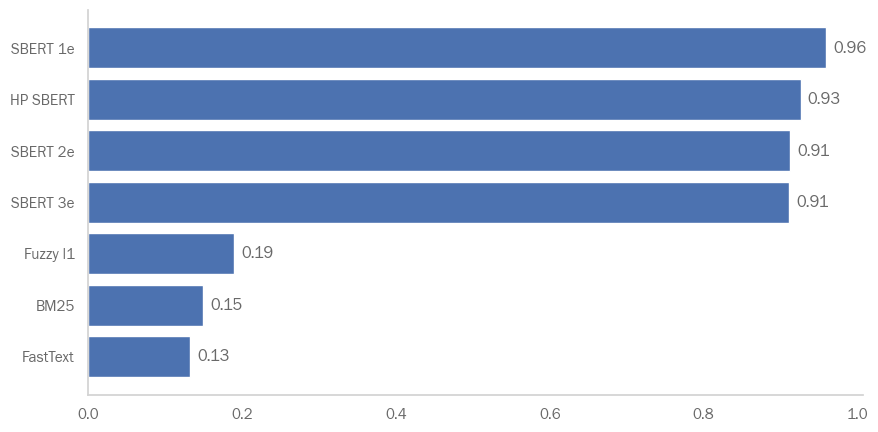

      model       MRR
3  SBERT 1e  0.959302
0  HP SBERT  0.926357
2  SBERT 2e  0.912791
1  SBERT 3e  0.911628
4  Fuzzy l1  0.189849
5      BM25  0.149317
6  FastText  0.132558


In [9]:
#df_MRR_scores = pd.read_csv('data/evaluations/MRR.csv') #Use this if the MRR evaluation isn't working
top100_models = df_MRR_scores[df_MRR_scores['model'].str.contains(r'^(?=.*top100)(?!.*top1000).*$')]
top100_models['model'] = top100_models['model'].str.replace('_top100.csv', '').str.replace('_', ' ')
top100_models = top100_models.sort_values(by='MRR', ascending=True)
render_MRR(MRR_results=top100_models, save_path='assets/MRR.png')
print(top100_models.sort_values(by='MRR', ascending=False))

### Score

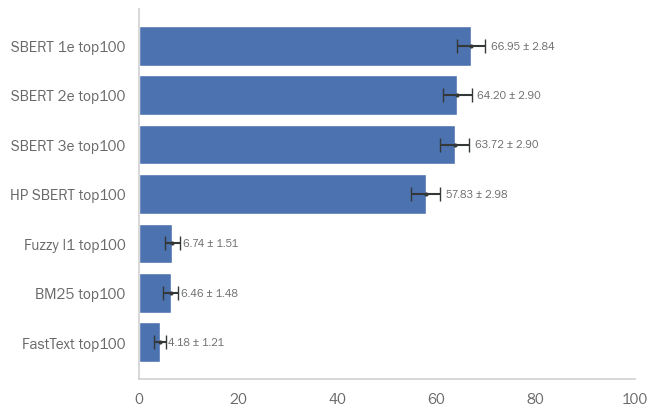

             Model          p  Margin of error  Lower bound  Upper bound
6  SBERT 1e top100  66.951567         2.841121    64.110446    69.792688
5  SBERT 2e top100  64.197531         2.895673    61.301858    67.093204
4  SBERT 3e top100  63.722697         2.904012    60.818685    66.626710
3  HP SBERT top100  57.834758         2.982673    54.852085    60.817431
2  Fuzzy l1 top100   6.742640         1.514574     5.228066     8.257214
1      BM25 top100   6.457740         1.484493     4.973247     7.942233
0  FastText top100   4.178538         1.208586     2.969952     5.387123


In [10]:
data_score = render_bar_chart(save_fig=False, topK=10, metric='score') # Beware, topK=10
df = to_table(data_score)
print(df)

### Count

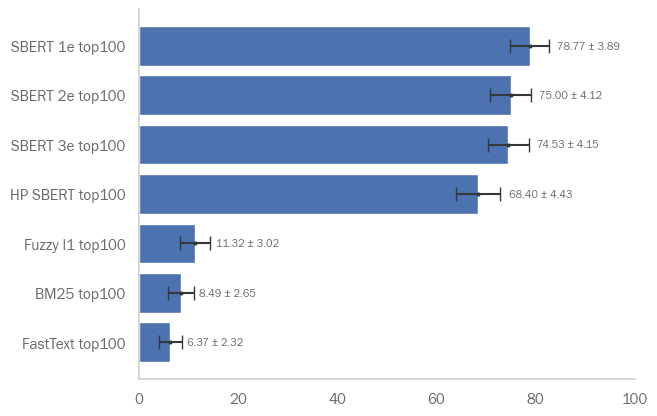

             Model          p  Margin of error  Lower bound  Upper bound
6  SBERT 1e top100  78.773585         3.892188    74.881397    82.665773
5  SBERT 2e top100  75.000000         4.121600    70.878400    79.121600
4  SBERT 3e top100  74.528302         4.147198    70.381104    78.675499
3  HP SBERT top100  68.396226         4.425381    63.970845    72.821608
2  Fuzzy l1 top100  11.320755         3.015879     8.304876    14.336633
1      BM25 top100   8.490566         2.653178     5.837388    11.143744
0  FastText top100   6.367925         2.324216     4.043709     8.692140


In [11]:
data_count = render_bar_chart(save_fig=False, topK=10, metric='count') # Beware, topK=10
df_count = to_table(data_count)
print(df_count)